In [1]:
# load libraries 
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
# set seeds
torch.manual_seed(2020)
np.random.seed(2020)

In [3]:
# load data
train = np.loadtxt("ECG200_TRAIN.txt")
test  = np.loadtxt("ECG200_TEST.txt")

# the first column is label
X_train = train[:, 1:]       
y_train = train[:, 0].astype(int)     
X_test  = test[:, 1:]              
y_test  = test[:, 0].astype(int)

# original label is -1, +1, we convert to 0, 1 for BCE
y_train = (y_train == 1).astype(np.float32)
y_test  = (y_test == 1).astype(np.float32)


# convert to torch tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test  = torch.tensor(X_test, dtype=torch.float32)
y_test  = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


print("X_train:", X_train.shape, "y_train:", y_train.shape)

X_train: torch.Size([100, 96]) y_train: torch.Size([100, 1])


In [4]:
# define a baseline NeuralNetwork

class NeuralNetwork1(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(96, 1)
        self.final = nn.Sigmoid()

    def forward(self, x):
        
        op = self.fc1(x)
        y = self.final(op)

        return y   

In [5]:
class NeuralNetwork2(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(96, 256)
        self.relu1 = nn.ReLU()
        
        self.out = nn.Linear(256, 1)
        self.final = nn.Sigmoid()

    def forward(self, x):
        
        op = self.fc1(x)
        op = self.relu1(op)
        
        op = self.out(op)
        y = self.final(op)

        return y      

In [6]:
def train_network(model, optimizer, loss_fn, num_epochs, batch_size, X_train, y_train, X_test, y_test):


    # record history
    train_loss_history = []
    test_loss_history  = []
    train_acc_history  = []
    test_acc_history   = []



    # training size
    N = X_train.shape[0]

    for epoch in range(num_epochs):
        
        # explicitly start model training
        model.train()

        for i in range(0, N, batch_size):

            # end index for each batch
            end = min(N, i + batch_size)

            # extract train batch from X and Y
            x_batch = X_train[i:end]
            y_batch = y_train[i:end]

            # set the gradients to zero before starting to do backpropragation
            optimizer.zero_grad()

            # forward pass
            y_pred = model(x_batch)

            # # caculate loss
            loss = loss_fn(y_pred, y_batch)

            # backpropogate
            loss.backward()

            # update weights
            optimizer.step()



        # explicitly set to evaluate mode
        model.eval()
        with torch.no_grad():

            # Train set
            train_prob = model(X_train)
            train_loss = loss_fn(train_prob, y_train).item()
            train_pred = (train_prob >= 0.5).float()
            train_acc  = (train_pred == y_train).float().mean().item()

            # Test set
            test_prob = model(X_test)
            test_loss = loss_fn(test_prob, y_test).item()
            test_pred = (test_prob >= 0.5).float()
            test_acc  = (test_pred == y_test).float().mean().item()

        train_loss_history.append(train_loss) 
        test_loss_history.append(test_loss)
        train_acc_history.append(train_acc)
        test_acc_history.append(test_acc)

        if epoch % 10 == 0:
            print(f"Epoch {epoch:3d} | TrainLoss={train_loss:.4f} | TestLoss={test_loss:.4f} | TrainAcc={train_acc:.3f} | TestAcc={test_acc:.3f}")

    return train_loss_history, test_loss_history, train_acc_history, test_acc_history


In [7]:
def plot_loss_and_accuracy(train_loss, test_loss, train_acc, test_acc):
    plt.figure(figsize=(12, 4))

    # loss
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label="Train Loss")
    plt.plot(test_loss,  label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Test Loss")
    plt.legend()

    # accuracy 
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(test_acc,  label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Test Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [8]:
# hyperparameters

num_epochs = 200
batch_size= 16

# binary Crosss Entropy Loss
loss_function = nn.BCELoss()  

# L2
weight_decay = 0.0

learning_rate = 0.001

# create a model instance
model = NeuralNetwork1()

# print the model size (number of parameters)
num_params = sum(p.numel() for p in model.parameters())
print("Number of parameters:", num_params)

Number of parameters: 97


In [9]:

# define optimizer
adam_optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay)

# train model
train_loss, test_loss, train_acc, test_acc = train_network(model, adam_optimizer, loss_function, num_epochs, batch_size, X_train, y_train, X_test, y_test)

Epoch   0 | TrainLoss=0.5805 | TestLoss=0.5805 | TrainAcc=0.780 | TestAcc=0.780
Epoch  10 | TrainLoss=0.3932 | TestLoss=0.4403 | TrainAcc=0.820 | TestAcc=0.790
Epoch  20 | TrainLoss=0.3500 | TestLoss=0.4209 | TrainAcc=0.850 | TestAcc=0.760
Epoch  30 | TrainLoss=0.3263 | TestLoss=0.4103 | TrainAcc=0.840 | TestAcc=0.760
Epoch  40 | TrainLoss=0.3102 | TestLoss=0.4030 | TrainAcc=0.850 | TestAcc=0.780
Epoch  50 | TrainLoss=0.2981 | TestLoss=0.3976 | TrainAcc=0.850 | TestAcc=0.790
Epoch  60 | TrainLoss=0.2883 | TestLoss=0.3938 | TrainAcc=0.860 | TestAcc=0.800
Epoch  70 | TrainLoss=0.2801 | TestLoss=0.3910 | TrainAcc=0.860 | TestAcc=0.800
Epoch  80 | TrainLoss=0.2730 | TestLoss=0.3890 | TrainAcc=0.850 | TestAcc=0.800
Epoch  90 | TrainLoss=0.2668 | TestLoss=0.3876 | TrainAcc=0.850 | TestAcc=0.810
Epoch 100 | TrainLoss=0.2611 | TestLoss=0.3867 | TrainAcc=0.840 | TestAcc=0.810
Epoch 110 | TrainLoss=0.2560 | TestLoss=0.3861 | TrainAcc=0.850 | TestAcc=0.810
Epoch 120 | TrainLoss=0.2513 | TestLoss=

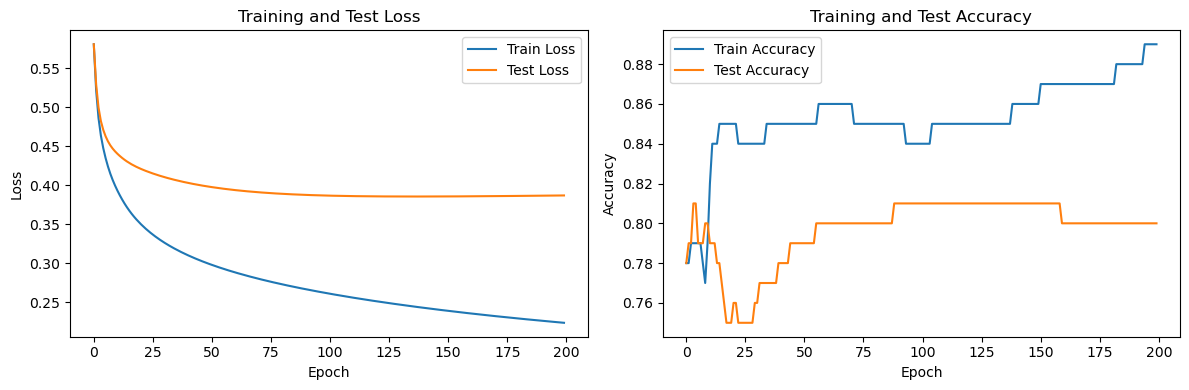

In [10]:
plot_loss_and_accuracy(train_loss, test_loss, train_acc, test_acc)

In [ ]:
# create a model instance
model = NeuralNetwork2()

# print the model size (number of parameters)
num_params = sum(p.numel() for p in model.parameters())
print("Number of parameters:", num_params)